# Train All Single Models
1. Boosting Decision Trees
   - GBR
   - LightGBM
   - XGBoostRegressor (the optimization version of GBDT by using L1/L2 regularization.)
2. RandomForest
   - RandomForest(RF)
   - ExtremeRandomTrees(ERT)
3. Kernel Ridge Regression(KRR)
4. K-Nearest Neighbor(KNN)
5. Support Vector Regressor(SVR)

In [18]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
# 
FIG_SHOW = False
np.random.seed(RANDOM_SEED)

In [19]:
current_path = os.getcwd()
current_path

'c:\\Users\\Fortyfour\\Desktop\\graduation_design\\New_Scripts\\Bg_pre2'

In [20]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path))
# Importing the custom module
from Utools.draw import plot_feature_importance
from Utools.SingleModel import SingleModel

In [21]:
from sklearn.base import clone
# Import sklearn models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyRegressor

## Load Data

In [22]:
# Load data
file_dir = os.path.join(current_path, './Data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'rfe_train_data', 'mp_train_set.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mp_test_set.csv'))
# exp data
exp_train = pd.read_csv(os.path.join(file_dir, 'rfe_train_data', 'exp_train_set.csv'))
exp_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'exp_test_set.csv'))
# mix test data
mix_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mix_test_set.csv'))

In [23]:
dft_train.shape, dft_test.shape, exp_train.shape, exp_test.shape, mix_test.shape

((7869, 119), (1963, 119), (2510, 119), (599, 119), (1198, 119))

In [24]:
dft_train.isna().any().any(), dft_test.isna().any().any(), exp_train.isna().any().any(), exp_test.isna().any().any(), mix_test.isna().any().any()

(np.False_, np.False_, np.False_, np.False_, np.False_)

In [25]:
dft_train_X = dft_train.drop(columns=['composition', 'band_gap'])
dft_train_y = dft_train['band_gap']
exp_train_X = exp_train.drop(columns=['composition', 'band_gap'])
exp_train_y = exp_train['band_gap']
dft_test_X = dft_test.drop(columns=['composition', 'band_gap'])
dft_test_y = dft_test['band_gap']
exp_test_X = exp_test.drop(columns=['composition', 'band_gap'])
exp_test_y = exp_test['band_gap']

mix_test = pd.read_csv(os.path.join(file_dir, 'rfe_test_data', 'mix_test_set.csv'))
mixed_test_X = mix_test.drop(columns=['composition', 'band_gap'])
mixed_test_y = mix_test['band_gap']

## Model Train

In [26]:
# define dft_models with the best hyper parameters
dft_models = {
    # Dummy models
    'Dummy': DummyRegressor(strategy='mean'),
    # GBDT models
    'GBR': GradientBoostingRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=10, 
    max_features=0.25, subsample=1.0, random_state=RANDOM_SEED),

    'LightGBM': LGBMRegressor(learning_rate=0.2, max_depth=-1, n_estimators=500,
    subsample=0.7, colsample_bytree=1.0,
    objective='regression', random_state=RANDOM_SEED, n_jobs=-1),

    'XGBoost': XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=500,
    colsample_bytree=0.7, subsample=1.0, reg_lambda=1.0, alpha=0.5, 
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1),

    # Random Forest models
    'RandomForest': RandomForestRegressor(
    n_estimators=500, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    max_features=0.25, random_state=RANDOM_SEED, n_jobs=-1),
    
    'ExtraRandomTrees': ExtraTreesRegressor(
    n_estimators=500, max_depth=None, min_samples_split=7, min_samples_leaf=1,
    max_features=0.5, random_state=RANDOM_SEED, n_jobs=-1),
    
    # 'KNN': KNeighborsRegressor(n_neighbors=5, weights='distance', metric='manhattan', p=2, n_jobs=-1),

    'KernelRidge': Pipeline([
    ('nystroem', Nystroem(kernel='rbf',  n_components=7500, random_state=RANDOM_SEED)),
    ('ridge', Ridge(alpha=0.05, random_state=RANDOM_SEED))]), 

    'SVR': SVR(kernel='rbf', C=25, epsilon=0.07, gamma=0.01)
}

In [27]:
# save model performance as df
metrics_df = pd.DataFrame(columns=['Model', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE', 'MAPE'])
# feature importance path
feature_importance_path = os.path.join(current_path, 'metrics', 'feature_importance')
os.makedirs(feature_importance_path, exist_ok=True)

In [28]:
# define exp_models with the best hyper parameters in the pervious step
exp_models = {
    # Dummy models
    'Dummy': DummyRegressor(strategy='mean'),
    # GBDT models
    'GBR': GradientBoostingRegressor(
    n_estimators=500, learning_rate=0.05, max_depth=7,
    max_features='sqrt', subsample=0.5, random_state=RANDOM_SEED),

    'LightGBM': LGBMRegressor(learning_rate=0.1, max_depth=-1, n_estimators=500,
    subsample=1.0, colsample_bytree=0.7,
    objective='regression', random_state=RANDOM_SEED, n_jobs=-1),
    
    'XGBoost': XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=500,
    colsample_bytree=0.7, subsample=0.9, reg_lambda=0.5, alpha=0.5,
    objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1),

    # Random Forest models
    'RandomForest': RandomForestRegressor(
    n_estimators=500, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    max_features=0.25, random_state=RANDOM_SEED, n_jobs=-1),
    
    'ExtraRandomTrees': ExtraTreesRegressor(
    n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    max_features=0.5, random_state=RANDOM_SEED, n_jobs=-1),

    # 'KNN': KNeighborsRegressor(n_neighbors=5, weights='distance', p=2, metric='manhattan', n_jobs=-1),
    'KernelRidge': Pipeline([
    ('nystroem', Nystroem(kernel='rbf',  n_components=2500, random_state=RANDOM_SEED)),
    ('ridge', Ridge(alpha=0.05, random_state=RANDOM_SEED))]),
    # SVM models
    # SVR's training time is too long, so we use Ya Zhuo et's hyper parameter
    'SVR': SVR(kernel='rbf', C=25, epsilon=0.07, gamma=0.01)
}

### DFT Model Train

In [29]:
model_number = 0
model_nums = len(dft_models)
# Loop through each model
for model_name, model in dft_models.items():
    model_number += 1
    # Create directories for figures
    fig_path = os.path.join(current_path, 'figures', 'Models', model_name)
    # Create directories if don't exist
    os.makedirs(fig_path, exist_ok=True)

    # record model metrics
    model_metrics = pd.DataFrame(columns=['Model', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE', 'MAPE'])

    # Train the model on dft data
    print("#" * 100)
    print(f"[{model_number}/{model_nums} - DFT - {model_name}] Training {model_name} on DFT data:")
    print("-" * 100)
    
    dft_model = SingleModel(clone(model), random_state=RANDOM_SEED)
    dft_model.train(dft_train_X, dft_train_y)
    # evaluate on the dft test set
    print(f"[1 - DFT->DFT] Evaluating DFT {model_name} on DFT test set:")
    
    metrics = dft_model.evaluate(dft_test_X, dft_test_y, fig_path=os.path.join(fig_path, 'dft_train_dft_test.png'), fig_show=FIG_SHOW)
    model_metrics.loc[len(model_metrics)] = {
    'Model': f"Single {model_name}",
    'Train_set': 'dft',
    'Test_set': 'dft',
    'R²': metrics['r2'],
    'RMSE': metrics['rmse'],
    'MAE': metrics['mae'],
    'MAPE': metrics['mape']
}
    # evaluate on the exp test set
    print(f"[2 - DFT->EXP] Evaluating DFT {model_name} on EXP test set:")

    metrics = dft_model.evaluate(exp_test_X, exp_test_y, fig_path=os.path.join(fig_path, 'dft_train_exp_test.png'), fig_show=FIG_SHOW)
    model_metrics.loc[len(model_metrics)] = {
    'Model': f"Single {model_name}",
    'Train_set': 'dft',
    'Test_set': 'exp',
    'R²': metrics['r2'],
    'RMSE': metrics['rmse'],
    'MAE': metrics['mae'],
    'MAPE': metrics['mape']
}
   
    # evaluate on the mixed test set
    print(f"[3 - DFT->MIX] Evaluating DFT {model_name} on mixed test set:")
    metrics = dft_model.evaluate(mixed_test_X, mixed_test_y, fig_path=os.path.join(fig_path, 'dft_train_mixed_test.png'), fig_show=FIG_SHOW)
    model_metrics.loc[len(model_metrics)] = {
    'Model': f"Single {model_name}",
    'Train_set': 'dft',
    'Test_set': 'mix',
    'R²': metrics['r2'],
    'RMSE': metrics['rmse'],
    'MAE': metrics['mae'],
    'MAPE': metrics['mape']
}

    metrics_df = pd.concat([metrics_df, model_metrics], ignore_index=True)
    #################################################
    # Feature importance plot
    # For models that support feature importance
    if model_name in ['GBR', 'LightGBM', 'XGBoost', 'RandomForest', 'ExtraRandomTrees']:
        # 
        print(f"Plotting feature importance for {model_name} on DFT data:")
        dft_importances_df = plot_feature_importance(dft_model.get_model(), dft_train_X.columns, top_n=10,
                            fig_path=os.path.join(fig_path, f'dft_feature_importance.png'), fig_show=FIG_SHOW)
        # Save the feature importance DataFrame to a CSV file
        dft_feature_importance_path = os.path.join(feature_importance_path, 'dft')
        os.makedirs(dft_feature_importance_path, exist_ok=True)
        dft_importances_df.to_csv(os.path.join(dft_feature_importance_path, f'dft_{model_name}_feature_importance.csv'), index=False)

####################################################################################################
[1/8 - DFT - Dummy] Training Dummy on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
Model training completed!
[1 - DFT->DFT] Evaluating DFT Dummy on DFT test set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\Models\Dummy\dft_train_dft_test.png

Model Evaluation Results:
Test set size: 1963
Test set: R²: -0.0002 RMSE: 0.8696 MAE: 0.7471 MAPE: 2159.8941%
[2 - DFT->EXP] Evaluating DFT Dummy on EXP test set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\Models\Dummy\dft_train_exp_test.png

Model Evaluation Results:
Test set size: 599
Test set: R²: -0.0053 RMSE: 0.8093 MAE: 

C:\Users\Fortyfour\AppData\Local\Temp\ipykernel_11780\2523748834.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, model_metrics], ignore_index=True)


[Pipeline] ............. (step 2 of 2) Processing model, total= 1.1min
Model training completed!
[1 - DFT->DFT] Evaluating DFT GBR on DFT test set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\Models\GBR\dft_train_dft_test.png

Model Evaluation Results:
Test set size: 1963
Test set: R²: 0.6743 RMSE: 0.4962 MAE: 0.3510 MAPE: 1366.0363%
[2 - DFT->EXP] Evaluating DFT GBR on EXP test set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\Models\GBR\dft_train_exp_test.png

Model Evaluation Results:
Test set size: 599
Test set: R²: -0.0157 RMSE: 0.8135 MAE: 0.6432 MAPE: 65.7603%
[3 - DFT->MIX] Evaluating DFT GBR on mixed test set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\Models\GBR\dft_train_mixed_test.png

Model Evaluation Results:
Test set size: 1198
Test set: R²: 0.3692 RMSE: 0.6676 MAE: 0.4958 MAPE: 97.1431%
Plotting feature importance for GBR on DFT data:

e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\Models\LightGBM\dft_train_dft_test.png

Model Evaluation Results:
Test set size: 1963
Test set: R²: 0.6522 RMSE: 0.5128 MAE: 0.3663 MAPE: 1629.4972%
[2 - DFT->EXP] Evaluating DFT LightGBM on EXP test set:


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\Models\LightGBM\dft_train_exp_test.png

Model Evaluation Results:
Test set size: 599
Test set: R²: -0.0564 RMSE: 0.8296 MAE: 0.6609 MAPE: 69.0871%
[3 - DFT->MIX] Evaluating DFT LightGBM on mixed test set:


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\Models\LightGBM\dft_train_mixed_test.png

Model Evaluation Results:
Test set size: 1198
Test set: R²: 0.3426 RMSE: 0.6815 MAE: 0.5084 MAPE: 101.1167%
Plotting feature importance for LightGBM on DFT data:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\Models\LightGBM\dft_feature_importance.png
####################################################################################################
[4/8 - DFT - XGBoost] Training XGBoost on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   6.0s
Model training completed!
[1 - DFT->DFT] Evaluating DFT XGBoost on DFT test set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scr

### EXP Model Train

In [30]:
model_number = 0
model_nums = len(exp_models)
# Loop through each model
for model_name, model in exp_models.items():
    model_number += 1
    # Create directories for figures
    fig_path = os.path.join(current_path, 'figures', 'Models', model_name)
    # Create directories if don't exist
    os.makedirs(fig_path, exist_ok=True)
    
    # record model metrics  
    model_metrics = pd.DataFrame(columns=['Model', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE', 'MAPE'])
    ################################################
    # Train the model on exp data
    print("#" * 100)
    print(f"[{model_number}/{model_nums} - EXP - {model_name}] Training {model_name} on EXP data:")
    print("-" * 100)

    exp_model = SingleModel(clone(model), random_state=RANDOM_SEED)
    exp_model.train(exp_train_X, exp_train_y)
    # evaluate on the exp test set
    print(f"[1 - EXP->EXP] Evaluating EXP {model_name} on EXP test set:")
    metrics = exp_model.evaluate(exp_test_X, exp_test_y, fig_path=os.path.join(fig_path, 'exp_train_exp_test.png'), fig_show=FIG_SHOW)
    model_metrics.loc[len(model_metrics)] = {
    'Model': f"Single {model_name}",
    'Train_set': 'exp',
    'Test_set': 'exp',
    'R²': metrics['r2'],
    'RMSE': metrics['rmse'],
    'MAE': metrics['mae'],
    'MAPE': metrics['mape']
}
    # evaluate on the dft test set
    print(f"[2 - EXP->DFT]Evaluating EXP {model_name} on DFT test set:")
    metrics = exp_model.evaluate(dft_test_X, dft_test_y, fig_path=os.path.join(fig_path, 'exp_train_dft_test.png'), fig_show=FIG_SHOW)
    model_metrics.loc[len(model_metrics)] = {
    'Model': f"Single {model_name}",
    'Train_set': 'exp',
    'Test_set': 'dft',
    'R²': metrics['r2'],
    'RMSE': metrics['rmse'],
    'MAE': metrics['mae'],
    'MAPE': metrics['mape']
}
    # evaluate on the mixed test set
    print(f"[3 - EXP->MIX] Evaluating EXP {model_name} on mixed test set:")
    metrics = exp_model.evaluate(mixed_test_X, mixed_test_y, fig_path=os.path.join(fig_path, 'exp_train_mixed_test.png'), fig_show=FIG_SHOW)
    model_metrics.loc[len(model_metrics)] = {
    'Model': f"Single {model_name}",
    'Train_set': 'exp',
    'Test_set': 'mix',
    'R²': metrics['r2'],
    'RMSE': metrics['rmse'],
    'MAE': metrics['mae'],
    'MAPE': metrics['mape']
}
    
    metrics_df = pd.concat([metrics_df, model_metrics], ignore_index=True)
    #################################################
    # Feature importance plot
    # For models that support feature importance
    if model_name in ['GBR', 'LightGBM', 'XGBoost', 'RandomForest', 'ExtraRandomTrees']:
        # 
        print(f"Plotting feature importance for {model_name} on EXP data:")
        exp_importances_df = plot_feature_importance(exp_model.get_model(), exp_train_X.columns, top_n=10,
                            fig_path=os.path.join(fig_path, f'exp_feature_importance.png'), fig_show=FIG_SHOW)
        # Save the feature importance DataFrame to a CSV file
        exp_feature_importance_path = os.path.join(feature_importance_path, 'exp')
        os.makedirs(exp_feature_importance_path, exist_ok=True)
        dft_importances_df.to_csv(os.path.join(exp_feature_importance_path, f'exp_{model_name}_feature_importance.csv'), index=False)  

####################################################################################################
[1/8 - EXP - Dummy] Training Dummy on EXP data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s
Model training completed!
[1 - EXP->EXP] Evaluating EXP Dummy on EXP test set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\Models\Dummy\exp_train_exp_test.png

Model Evaluation Results:
Test set size: 599
Test set: R²: -0.0109 RMSE: 0.8115 MAE: 0.6882 MAPE: 138.1998%
[2 - EXP->DFT]Evaluating EXP Dummy on DFT test set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\Models\Dummy\exp_train_dft_test.png

Model Evaluation Results:
Test set size: 1963
Test set: R²: -0.0018 RMSE: 0.8703 MAE: 0.

e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\Models\LightGBM\exp_train_exp_test.png

Model Evaluation Results:
Test set size: 599
Test set: R²: 0.7496 RMSE: 0.4039 MAE: 0.2910 MAPE: 40.8562%
[2 - EXP->DFT]Evaluating EXP LightGBM on DFT test set:


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\Models\LightGBM\exp_train_dft_test.png

Model Evaluation Results:
Test set size: 1963
Test set: R²: -0.0552 RMSE: 0.8932 MAE: 0.6960 MAPE: 2797.4814%
[3 - EXP->MIX] Evaluating EXP LightGBM on mixed test set:


e:\software2\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\Models\LightGBM\exp_train_mixed_test.png

Model Evaluation Results:
Test set size: 1198
Test set: R²: 0.3471 RMSE: 0.6792 MAE: 0.4892 MAPE: 213.9922%
Plotting feature importance for LightGBM on EXP data:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\Bg_pre2\figures\Models\LightGBM\exp_feature_importance.png
####################################################################################################
[4/8 - EXP - XGBoost] Training XGBoost on EXP data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.6s
Model training completed!
[1 - EXP->EXP] Evaluating EXP XGBoost on EXP test set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scr

## Analysis

In [31]:
metrics_df.sort_values(by='RMSE', ascending=True).head(20)

,Model,Train_set,Test_set,R²,RMSE,MAE,MAPE
27,Single GBR,exp,exp,0.752417,0.401613,0.292153,41.812457
30,Single LightGBM,exp,exp,0.749581,0.403907,0.291029,40.856231
42,Single KernelRidge,exp,exp,0.747970,0.405204,0.292974,41.727295
33,Single XGBoost,exp,exp,0.746110,0.406696,0.299727,41.257460
36,Single RandomForest,exp,exp,0.735691,0.414957,0.308599,44.955021
39,Single ExtraRandomTrees,exp,exp,0.729393,0.419873,0.305991,45.035904
45,Single SVR,exp,exp,0.702426,0.440296,0.313226,42.650171
3,Single GBR,dft,dft,0.674300,0.496236,0.350958,1366.036324
9,Single XGBoost,dft,dft,0.672557,0.497562,0.350446,1768.524391
15,Single ExtraRandomTrees,dft,dft,0.661547,0.505858,0.364520,1591.355507


- **XGBoost** model is the best model for dft data
- **ExtraRandomTrees** model is the best model for exp data


In [32]:
# save the final metrics dataframe
os.makedirs(os.path.join(current_path, 'metrics'), exist_ok=True)
metrics_df.to_csv(os.path.join(current_path, 'metrics', 'single_model_metrics.csv'), index=False)

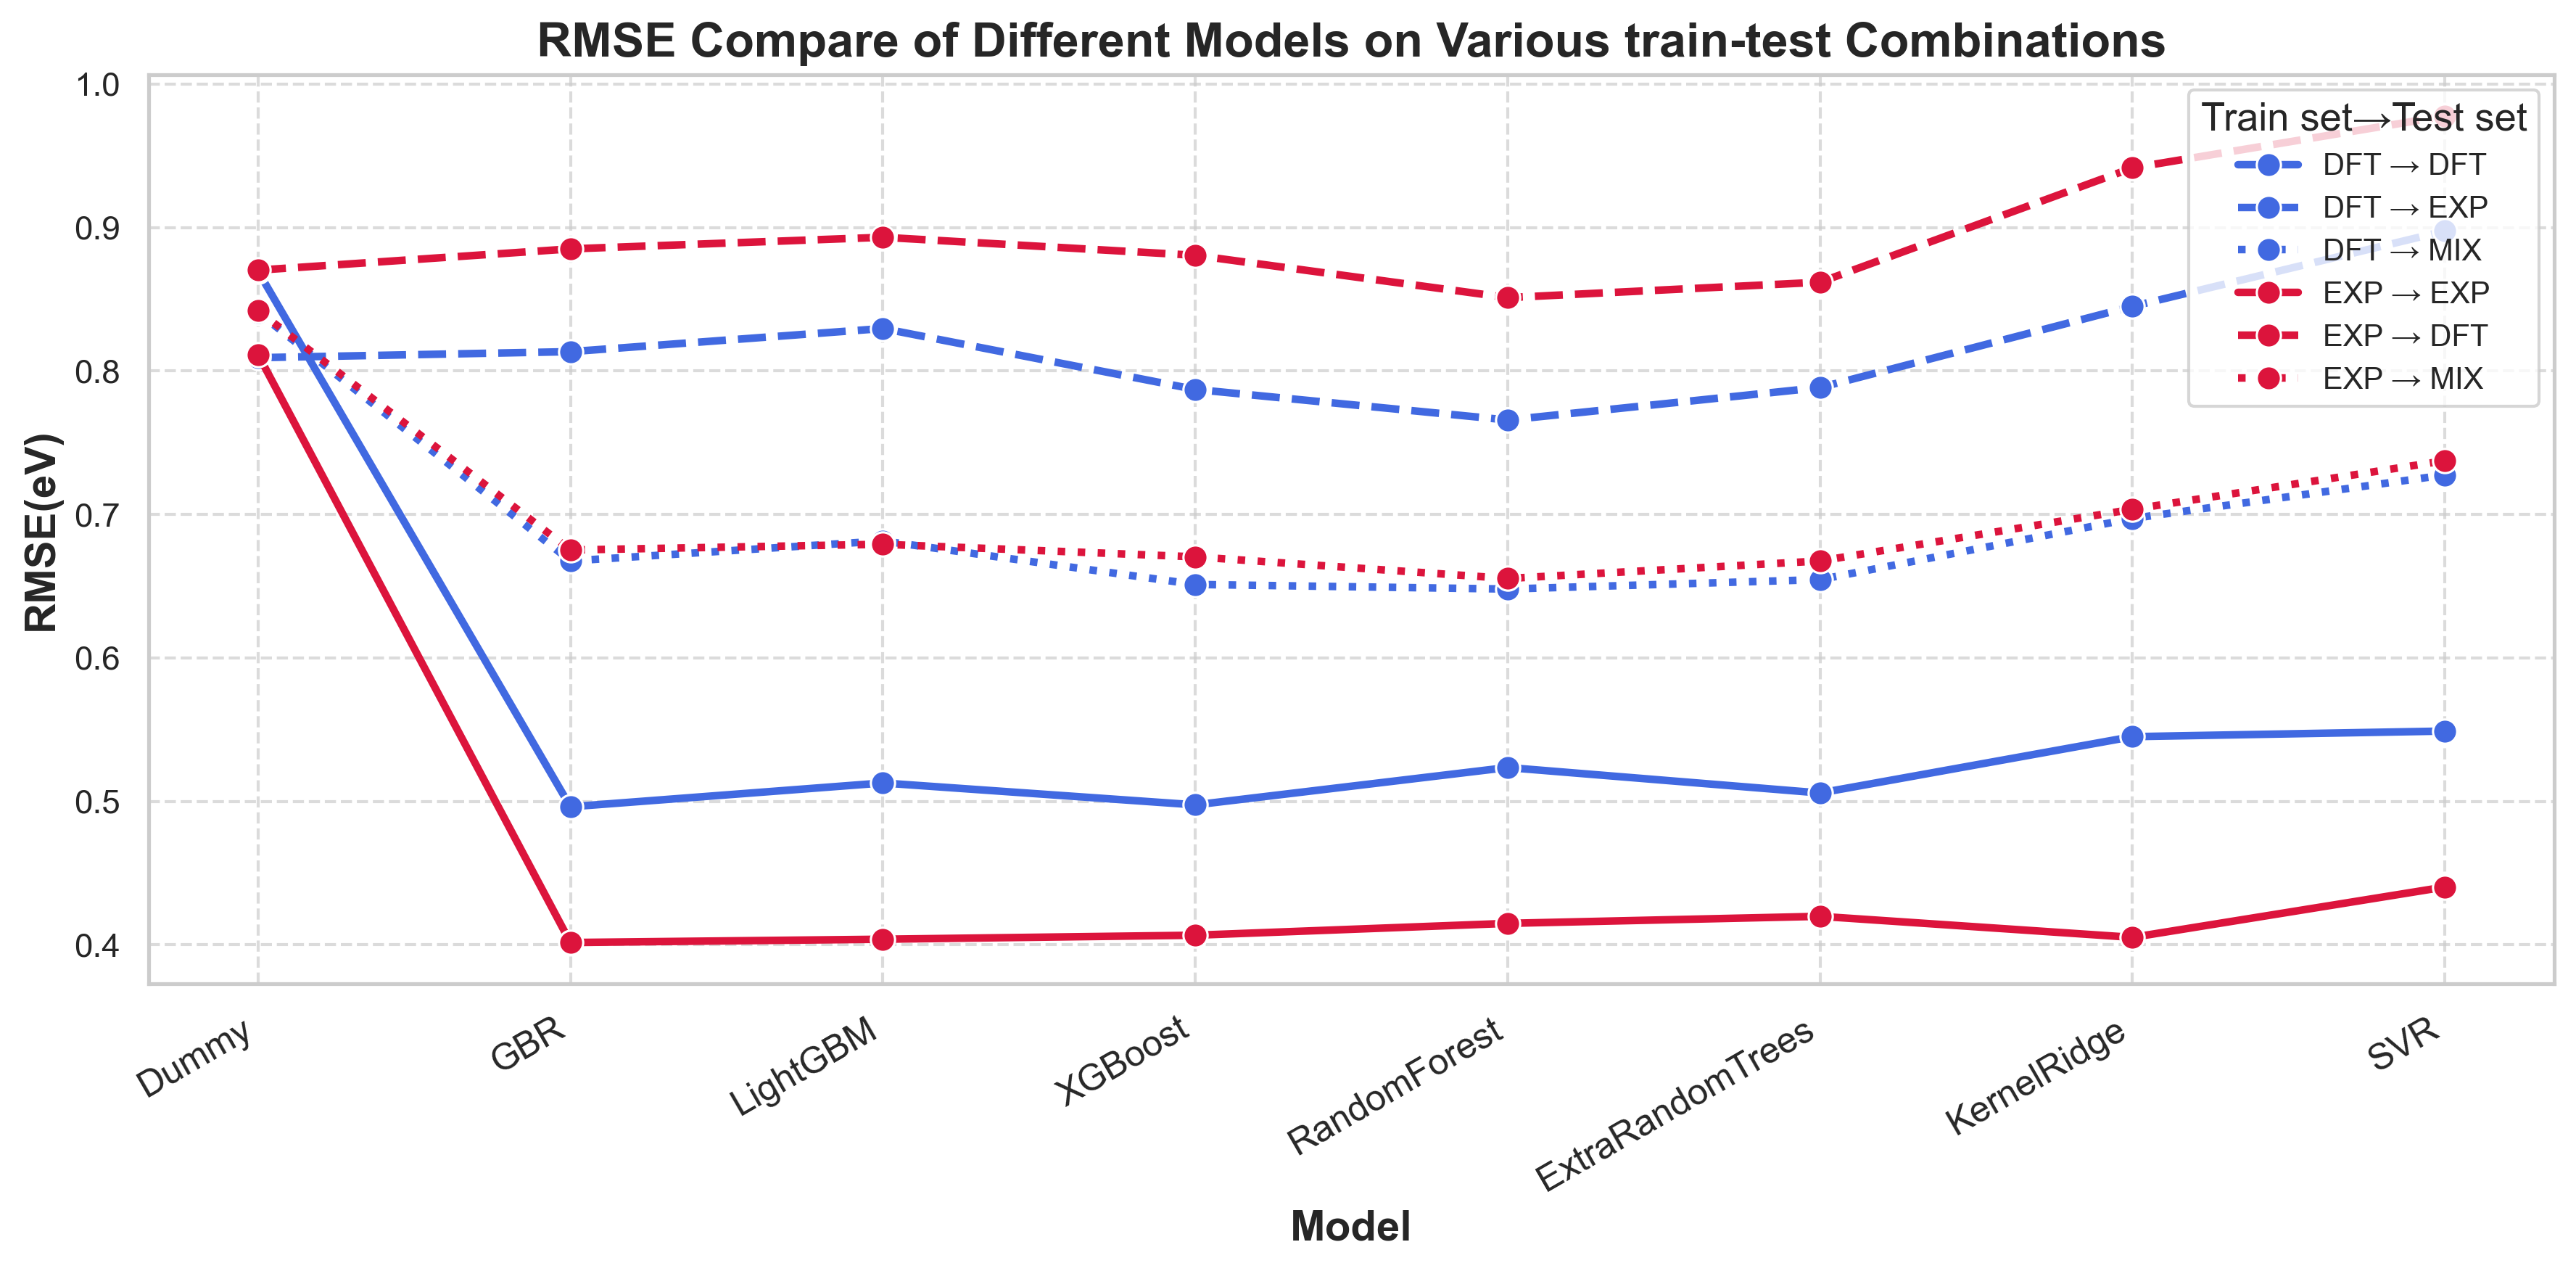

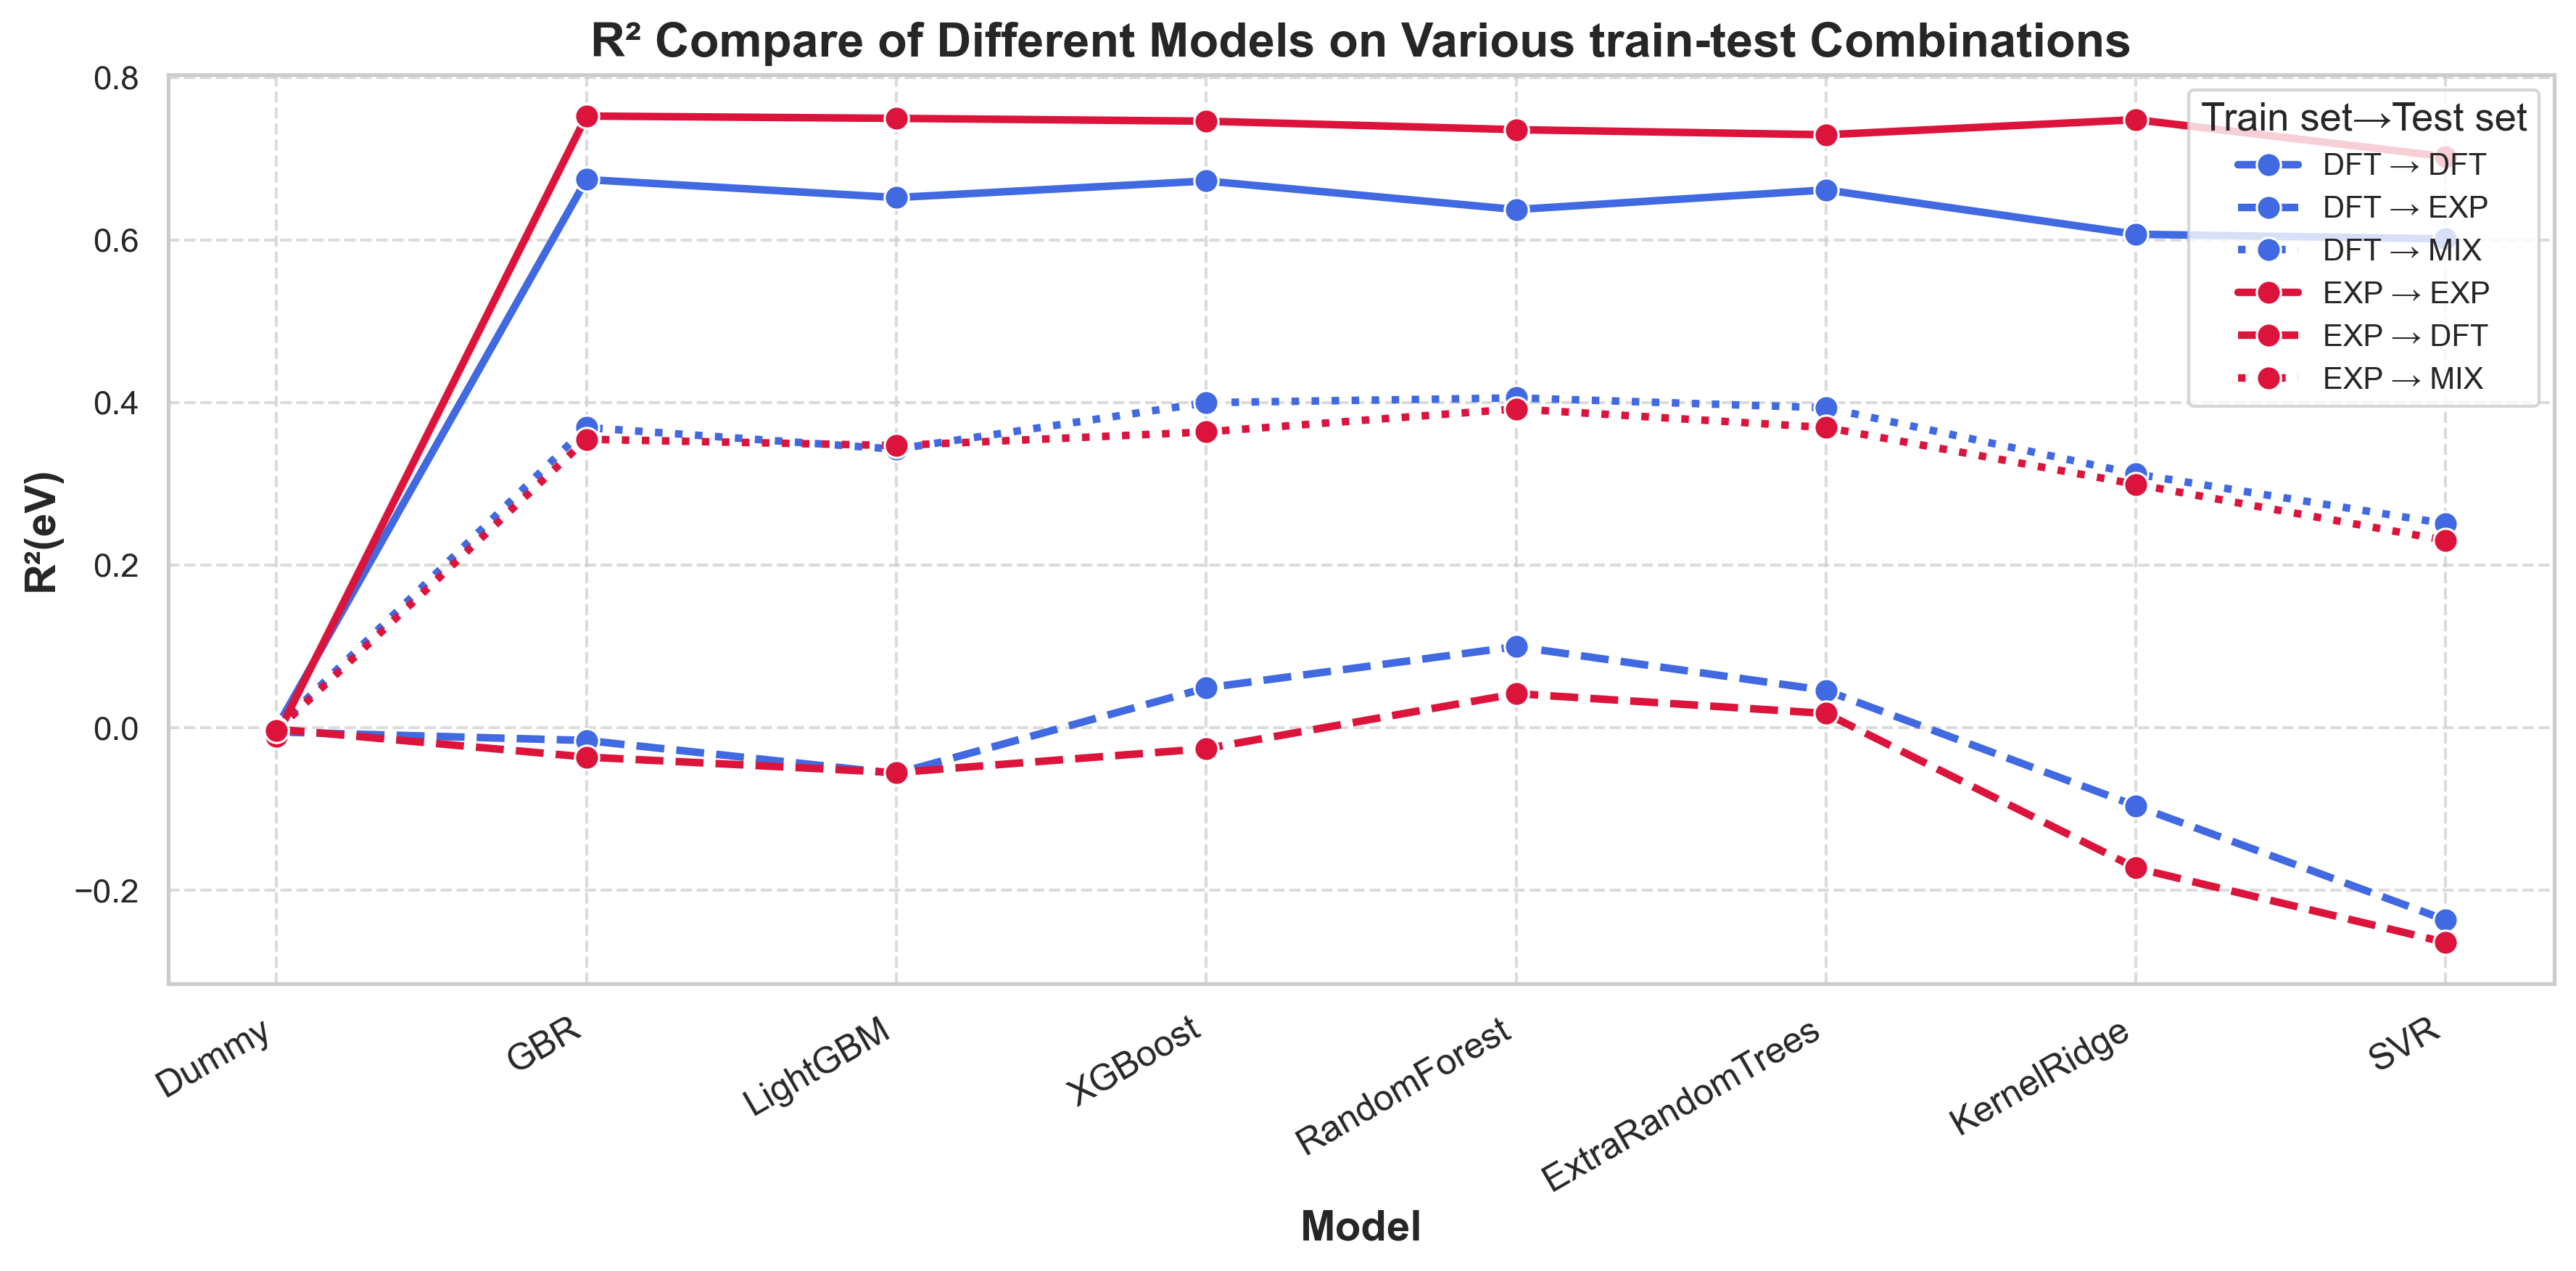

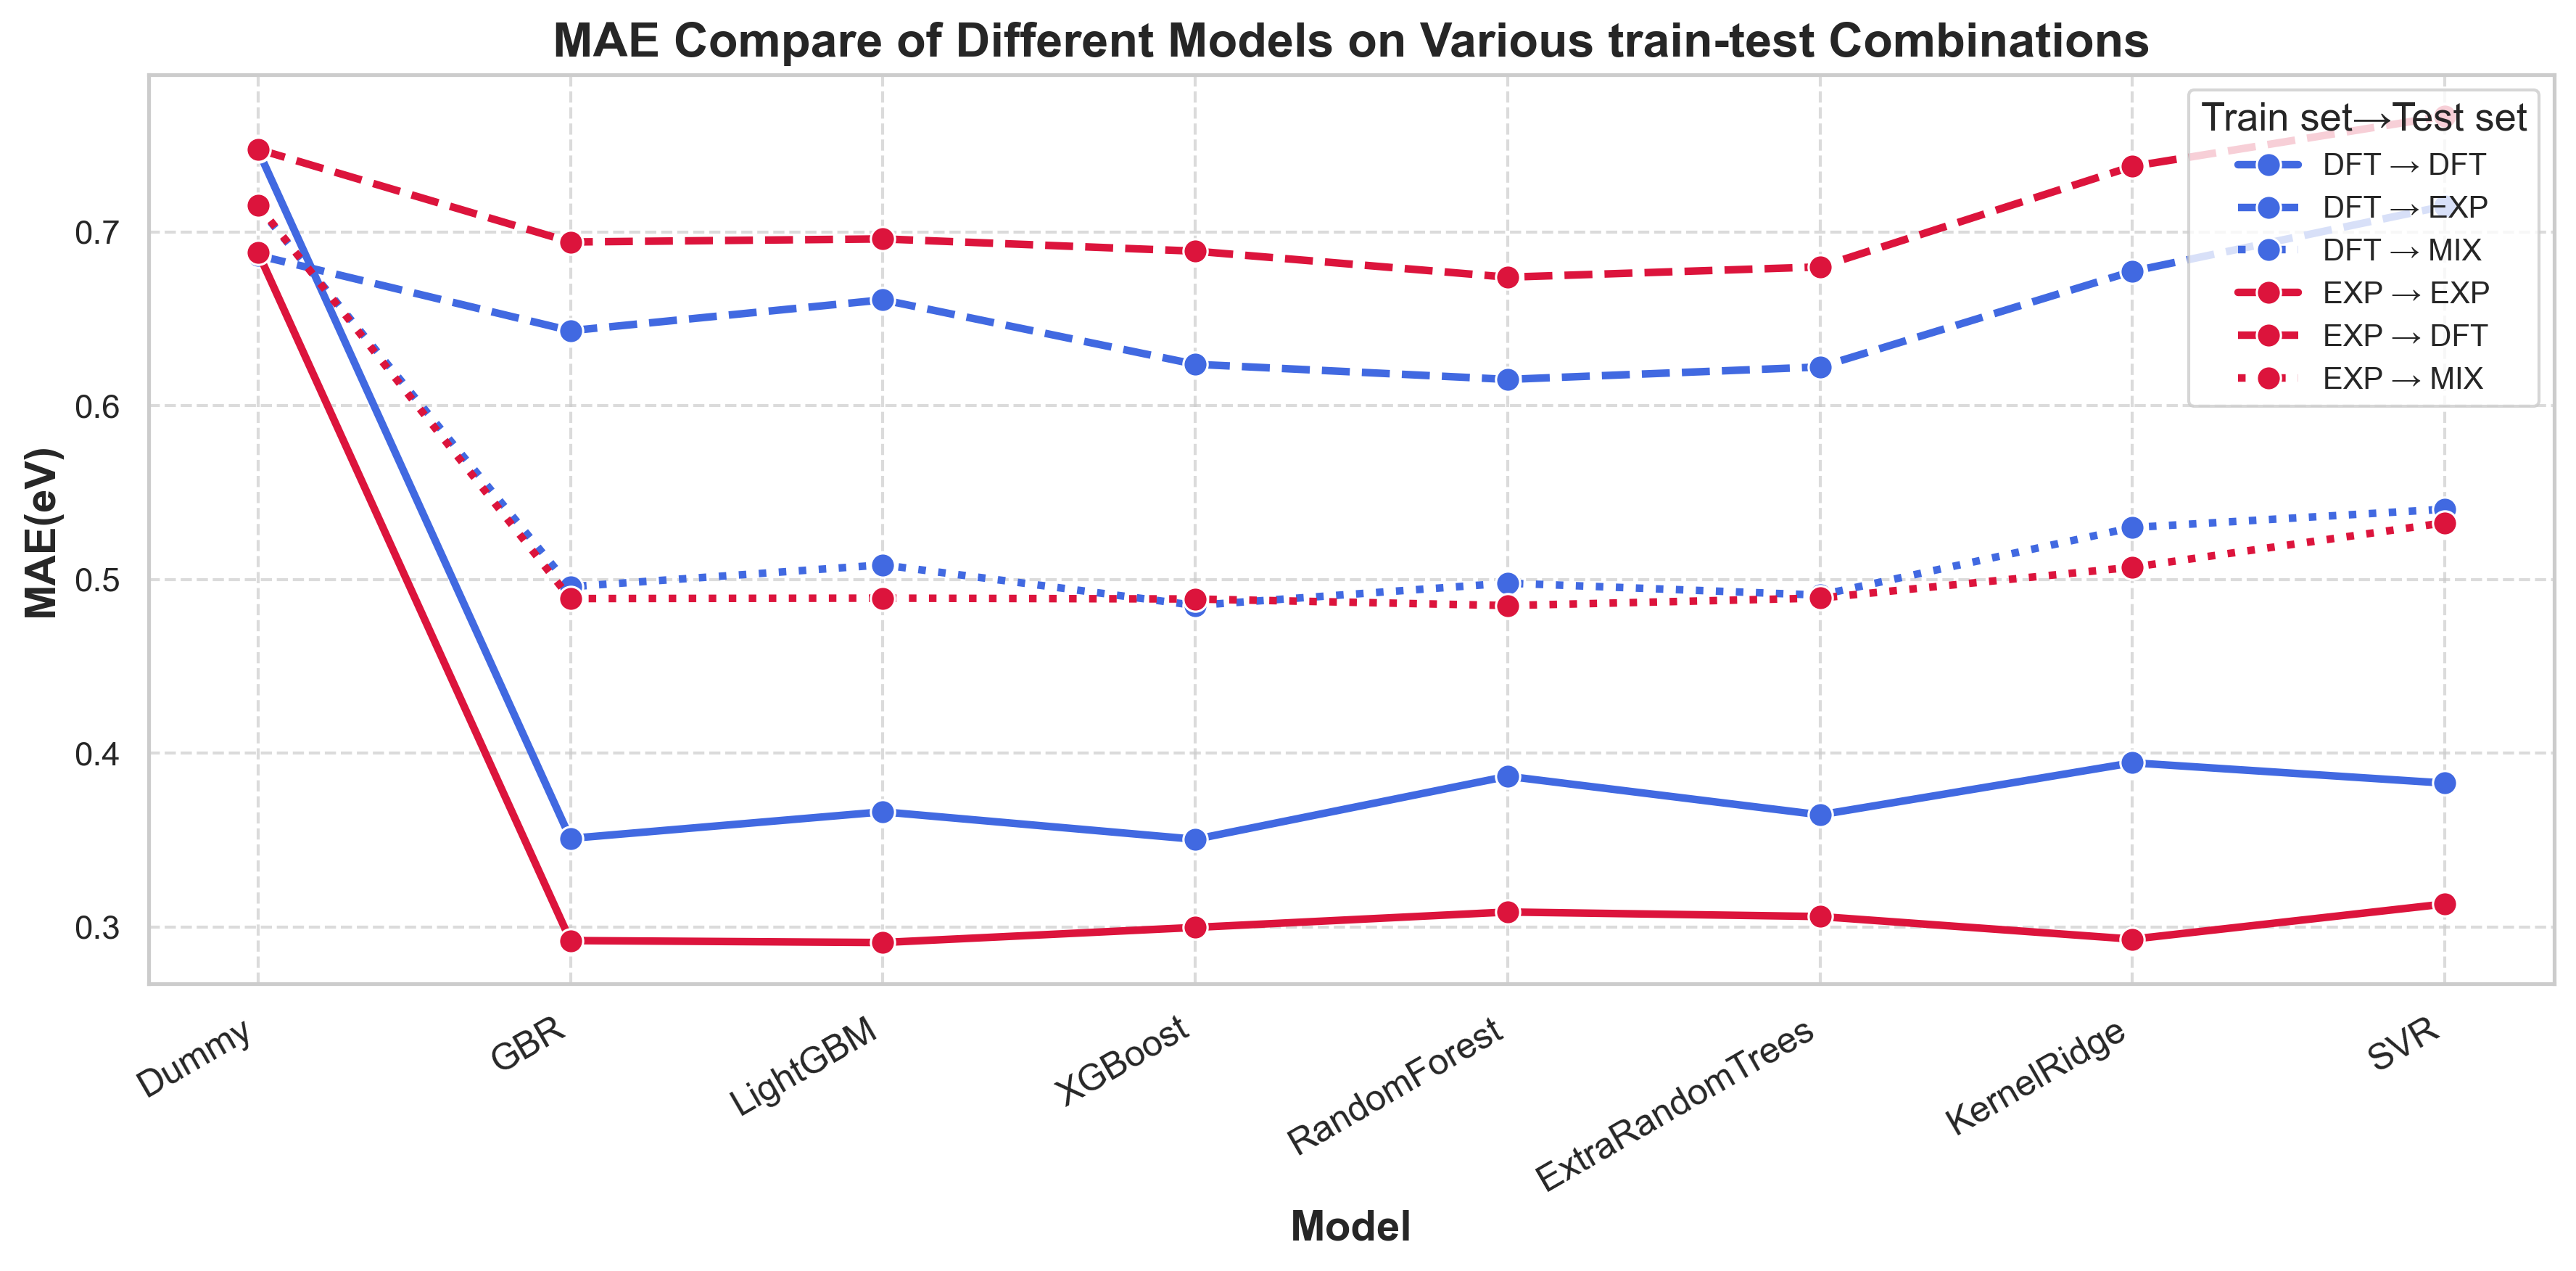

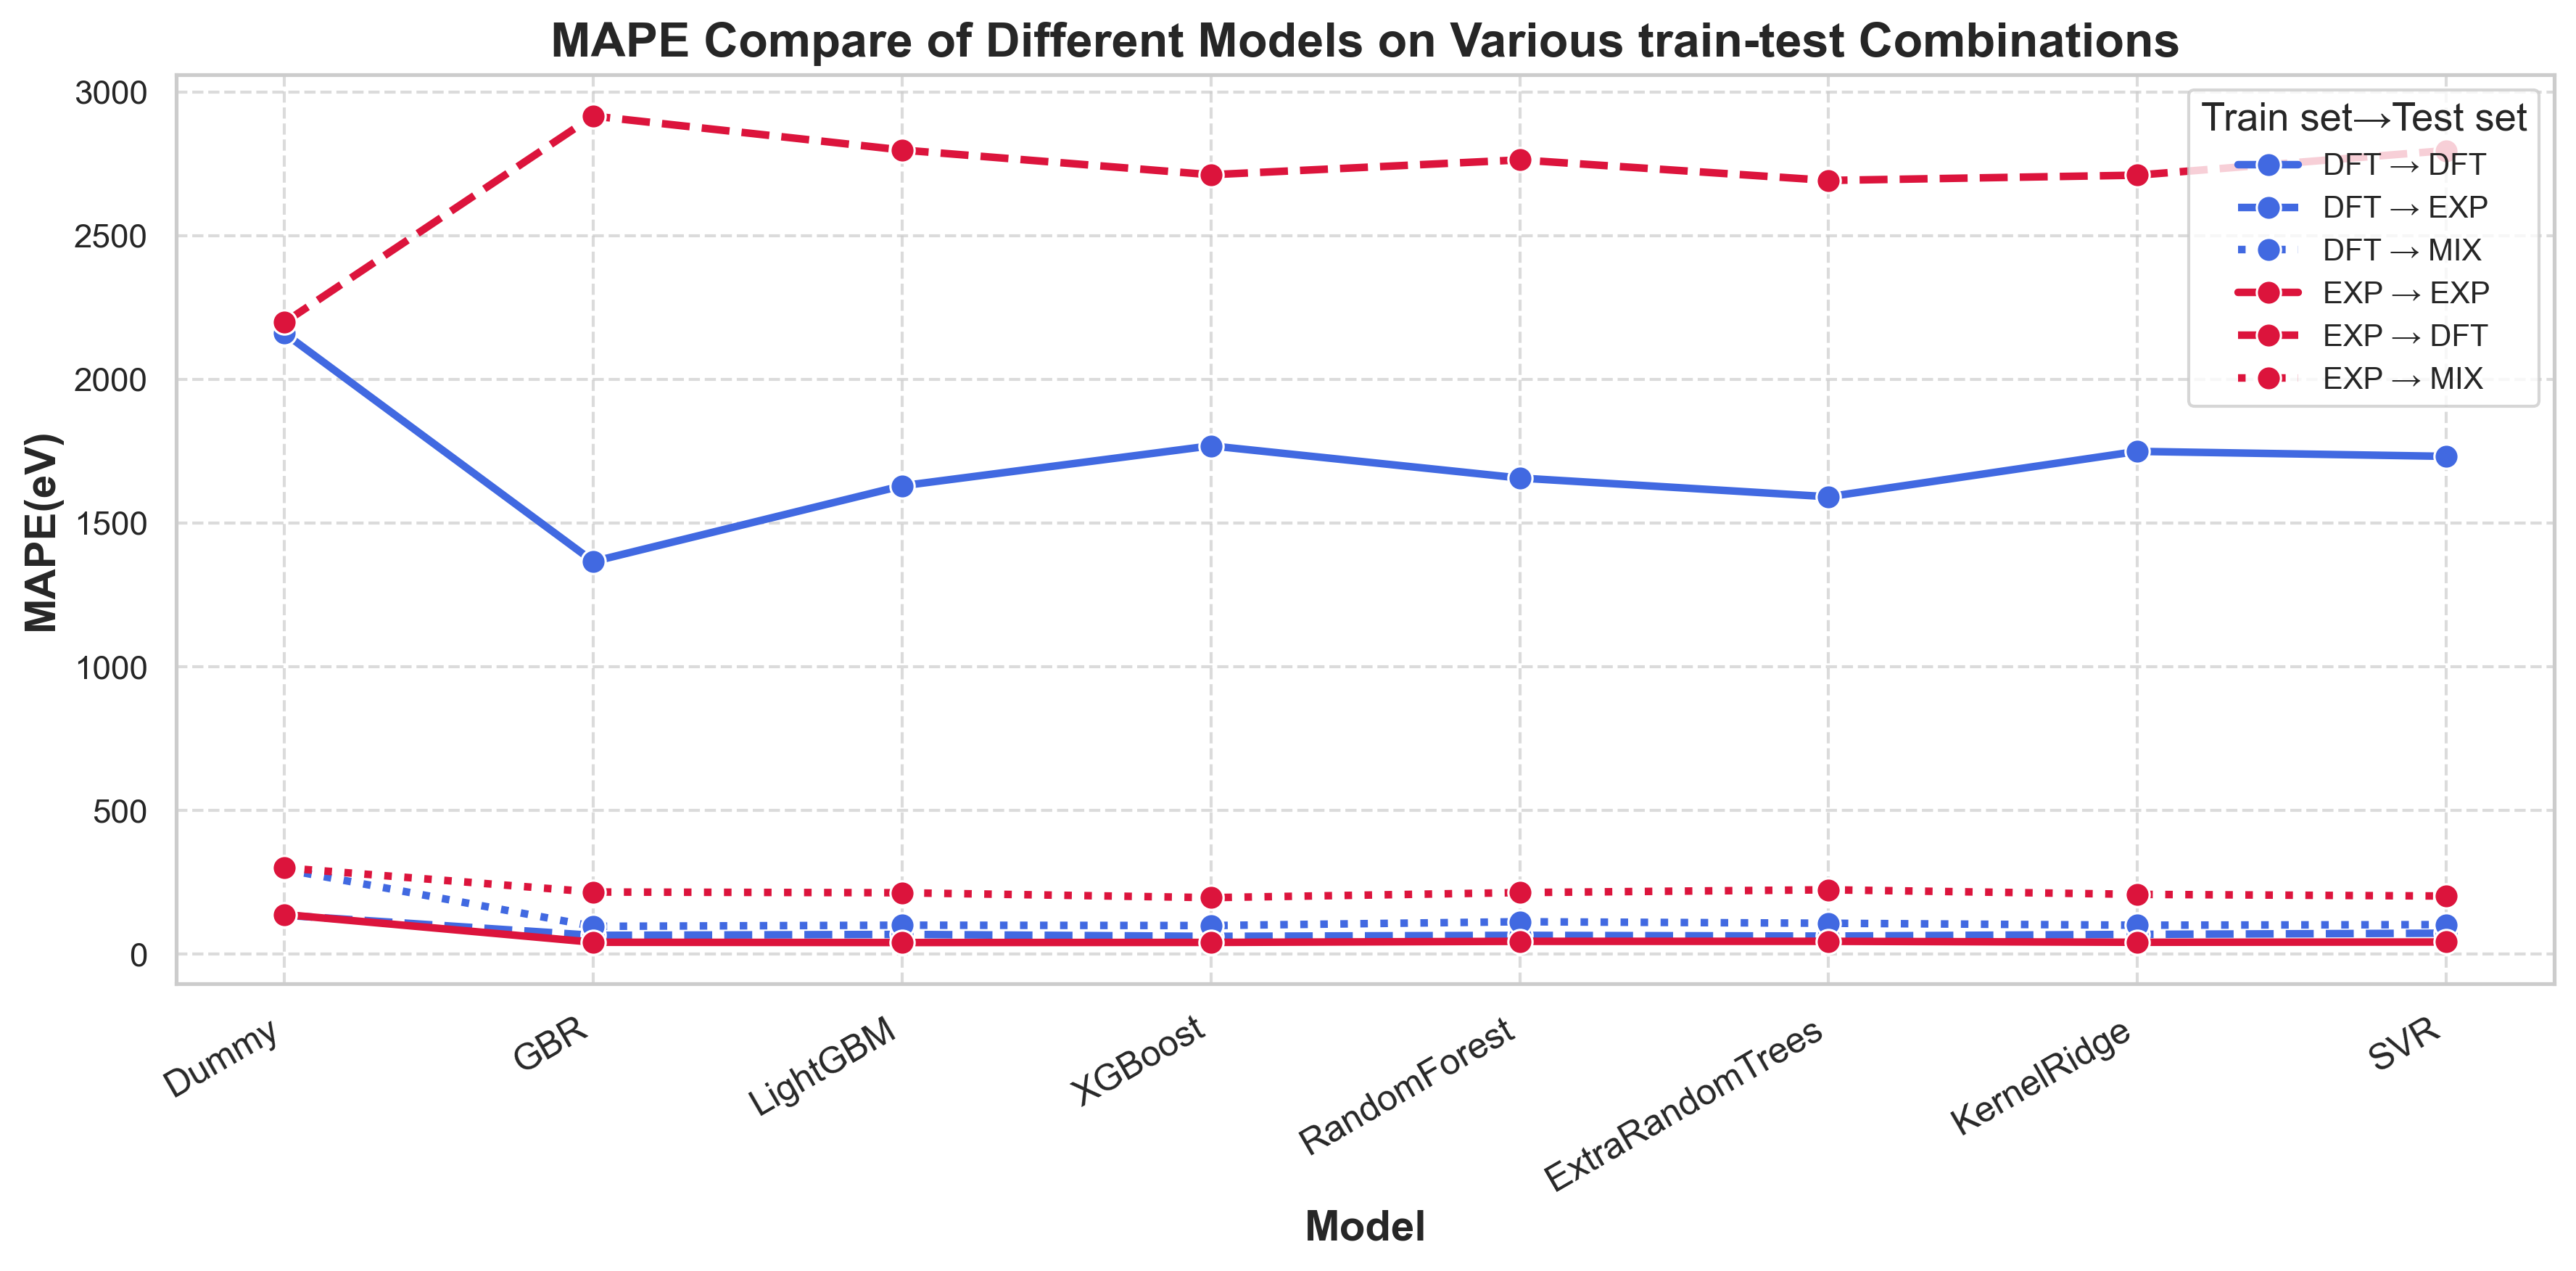

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. draw the metrics comparison figure

for metric_name in ['RMSE', 'R²', 'MAE', 'MAPE']:

    # set style
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6), dpi=300)

    # get unique models
    models = exp_models.keys()

    # prepare data for plotting
    plot_data = []
    for model in models:
        model_metrics = metrics_df[metrics_df['Model'] == f"Single {model}"]
        for _, row in model_metrics.iterrows():
            plot_data.append({
                'Model': row['Model'].split(' ')[-1],
                'Training': row['Train_set'],
                'Testing': row['Test_set'],
                metric_name: row[metric_name]
            })

    plot_df = pd.DataFrame(plot_data)

    # set line styles for different training-testing combinations
    # same dataset training and testing: solid line
    # different dataset training and testing: dashed line
    # dft training: blue; exp training: red
    line_styles = {
        ('dft', 'dft'): {'color': 'royalblue', 'linestyle': '-', 'label': 'DFT → DFT'},
        ('dft', 'exp'): {'color': 'royalblue', 'linestyle': '--', 'label': 'DFT → EXP'},
        ('dft', 'mix'): {'color': 'royalblue', 'linestyle': 'dotted', 'label': 'DFT → MIX'},

        ('exp', 'exp'): {'color': 'crimson', 'linestyle': '-', 'label': 'EXP → EXP'},
        ('exp', 'dft'): {'color': 'crimson', 'linestyle': '--', 'label': 'EXP → DFT'},
        ('exp', 'mix'): {'color': 'crimson', 'linestyle': 'dotted', 'label': 'EXP → MIX'}
    }

    # plot lines for each model
    for (train_set, test_set), style in line_styles.items():
        data = plot_df[(plot_df['Training'] == train_set) & (plot_df['Testing'] == test_set)]
        if not data.empty:
            sns.lineplot(
                data=data,
                x='Model',
                y=metric_name,
                marker='o',
                markersize=8,
                linewidth=2.5,
                **style
            )

    # beautify the plot
    plt.title(f'{metric_name} Compare of Different Models on Various train-test Combinations', fontsize=16, weight='bold')
    plt.xlabel('Model', fontsize=14, weight='bold')
    plt.ylabel(f'{metric_name}(eV)', fontsize=14, weight='bold')
    plt.xticks(rotation=30, ha='right', fontsize=12)
    # set the legend on the right top corner
    plt.legend(title='Train set→Test set', loc='upper right', fontsize=10, title_fontsize=13)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()  # adjust layout to fit all elements

    # add figure text
    # plt.figtext(0.5, 0.01, 
    #            'Solid: train and test on the same type set | Dashes: train and test on the different type set\n'
    #            'Blue: train on DFT set | Red: train on EXP set\n', 
    #            ha='center', fontsize=11)

    # save the figure
    fig_path = os.path.join(current_path, 'figures', 'metrics_comparison', 'dft_exp')
    os.makedirs(fig_path, exist_ok=True)
    plt.savefig(os.path.join(fig_path, f'{metric_name}_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

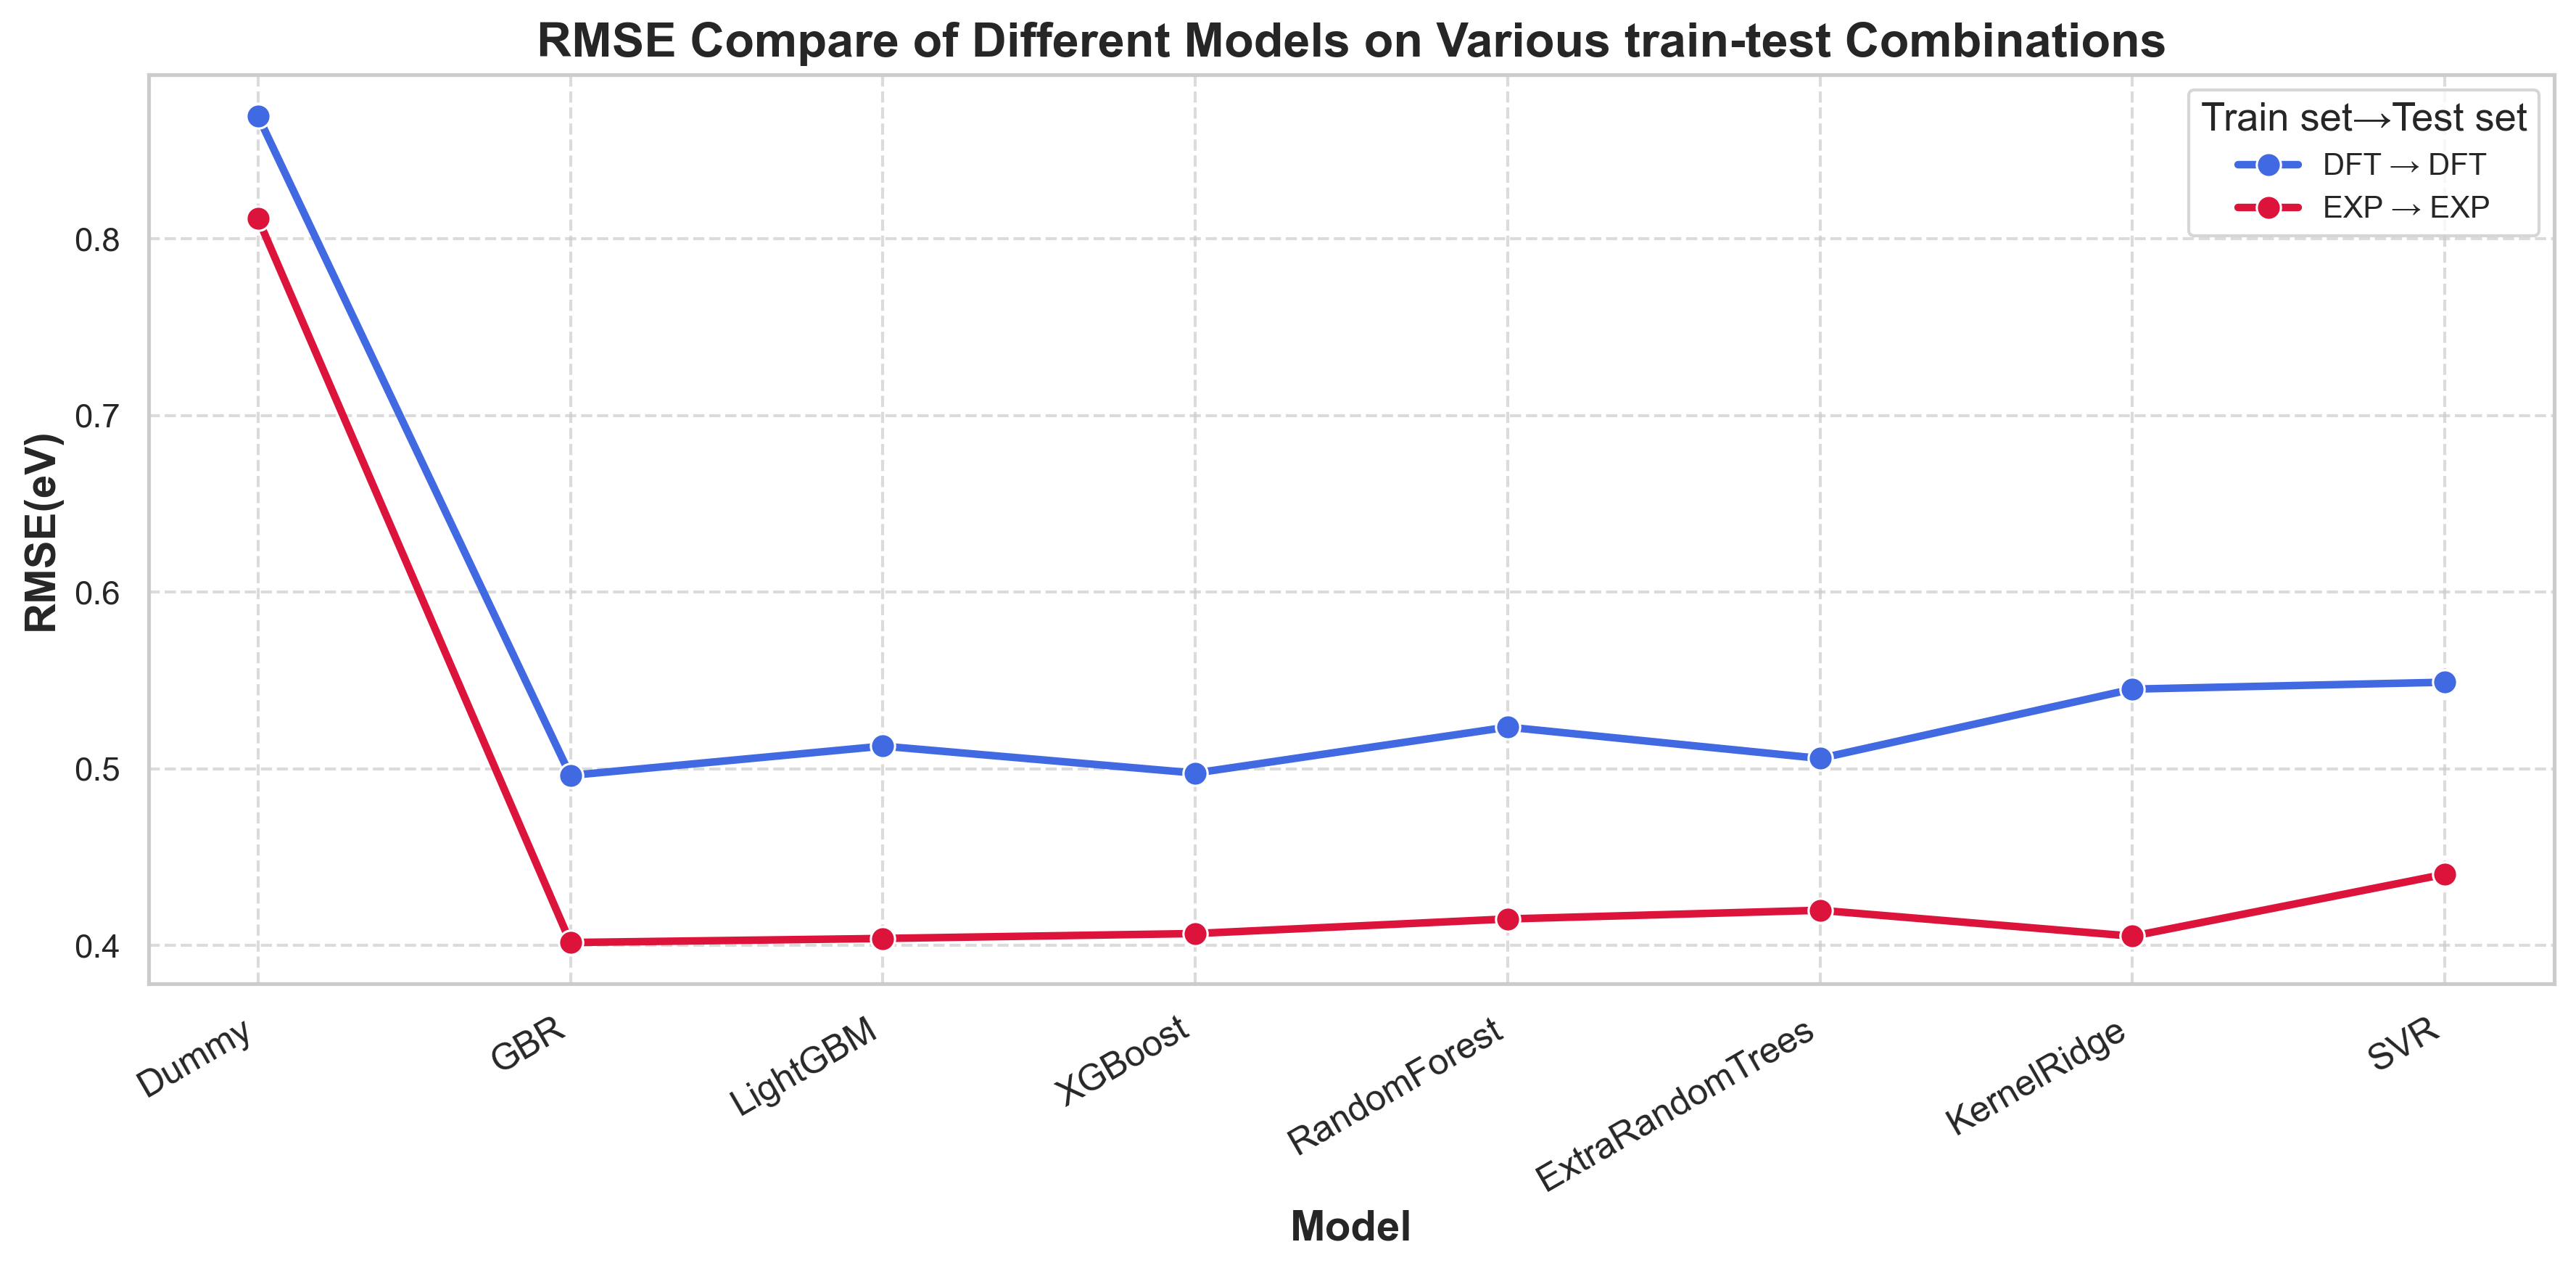

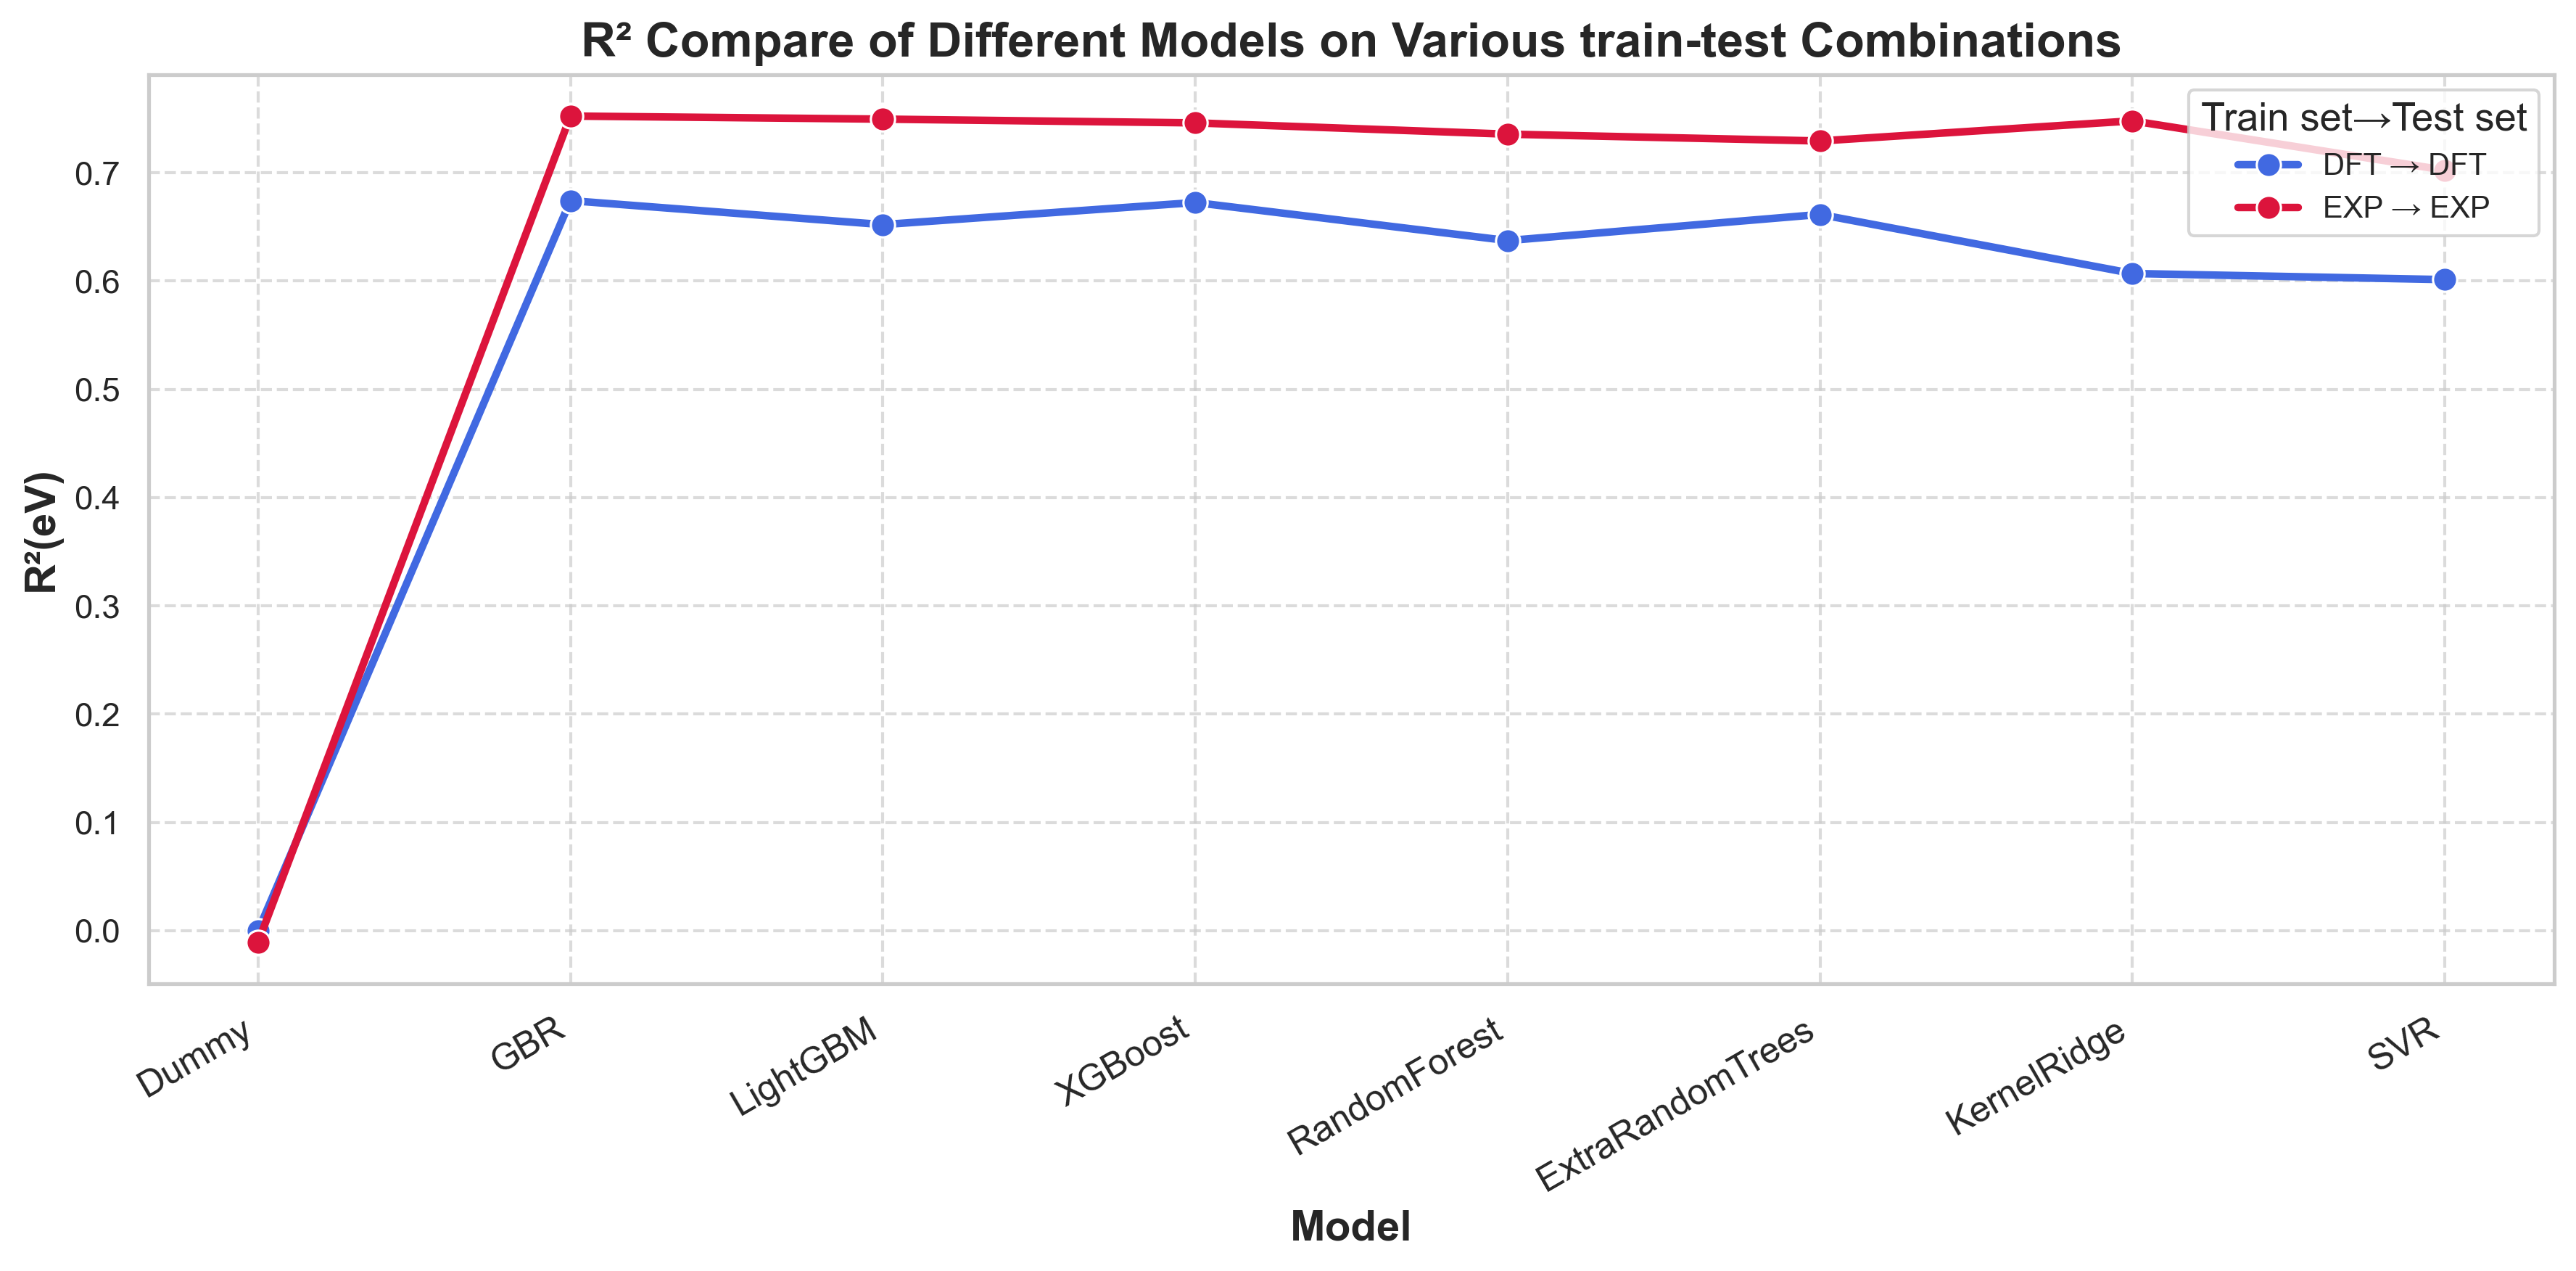

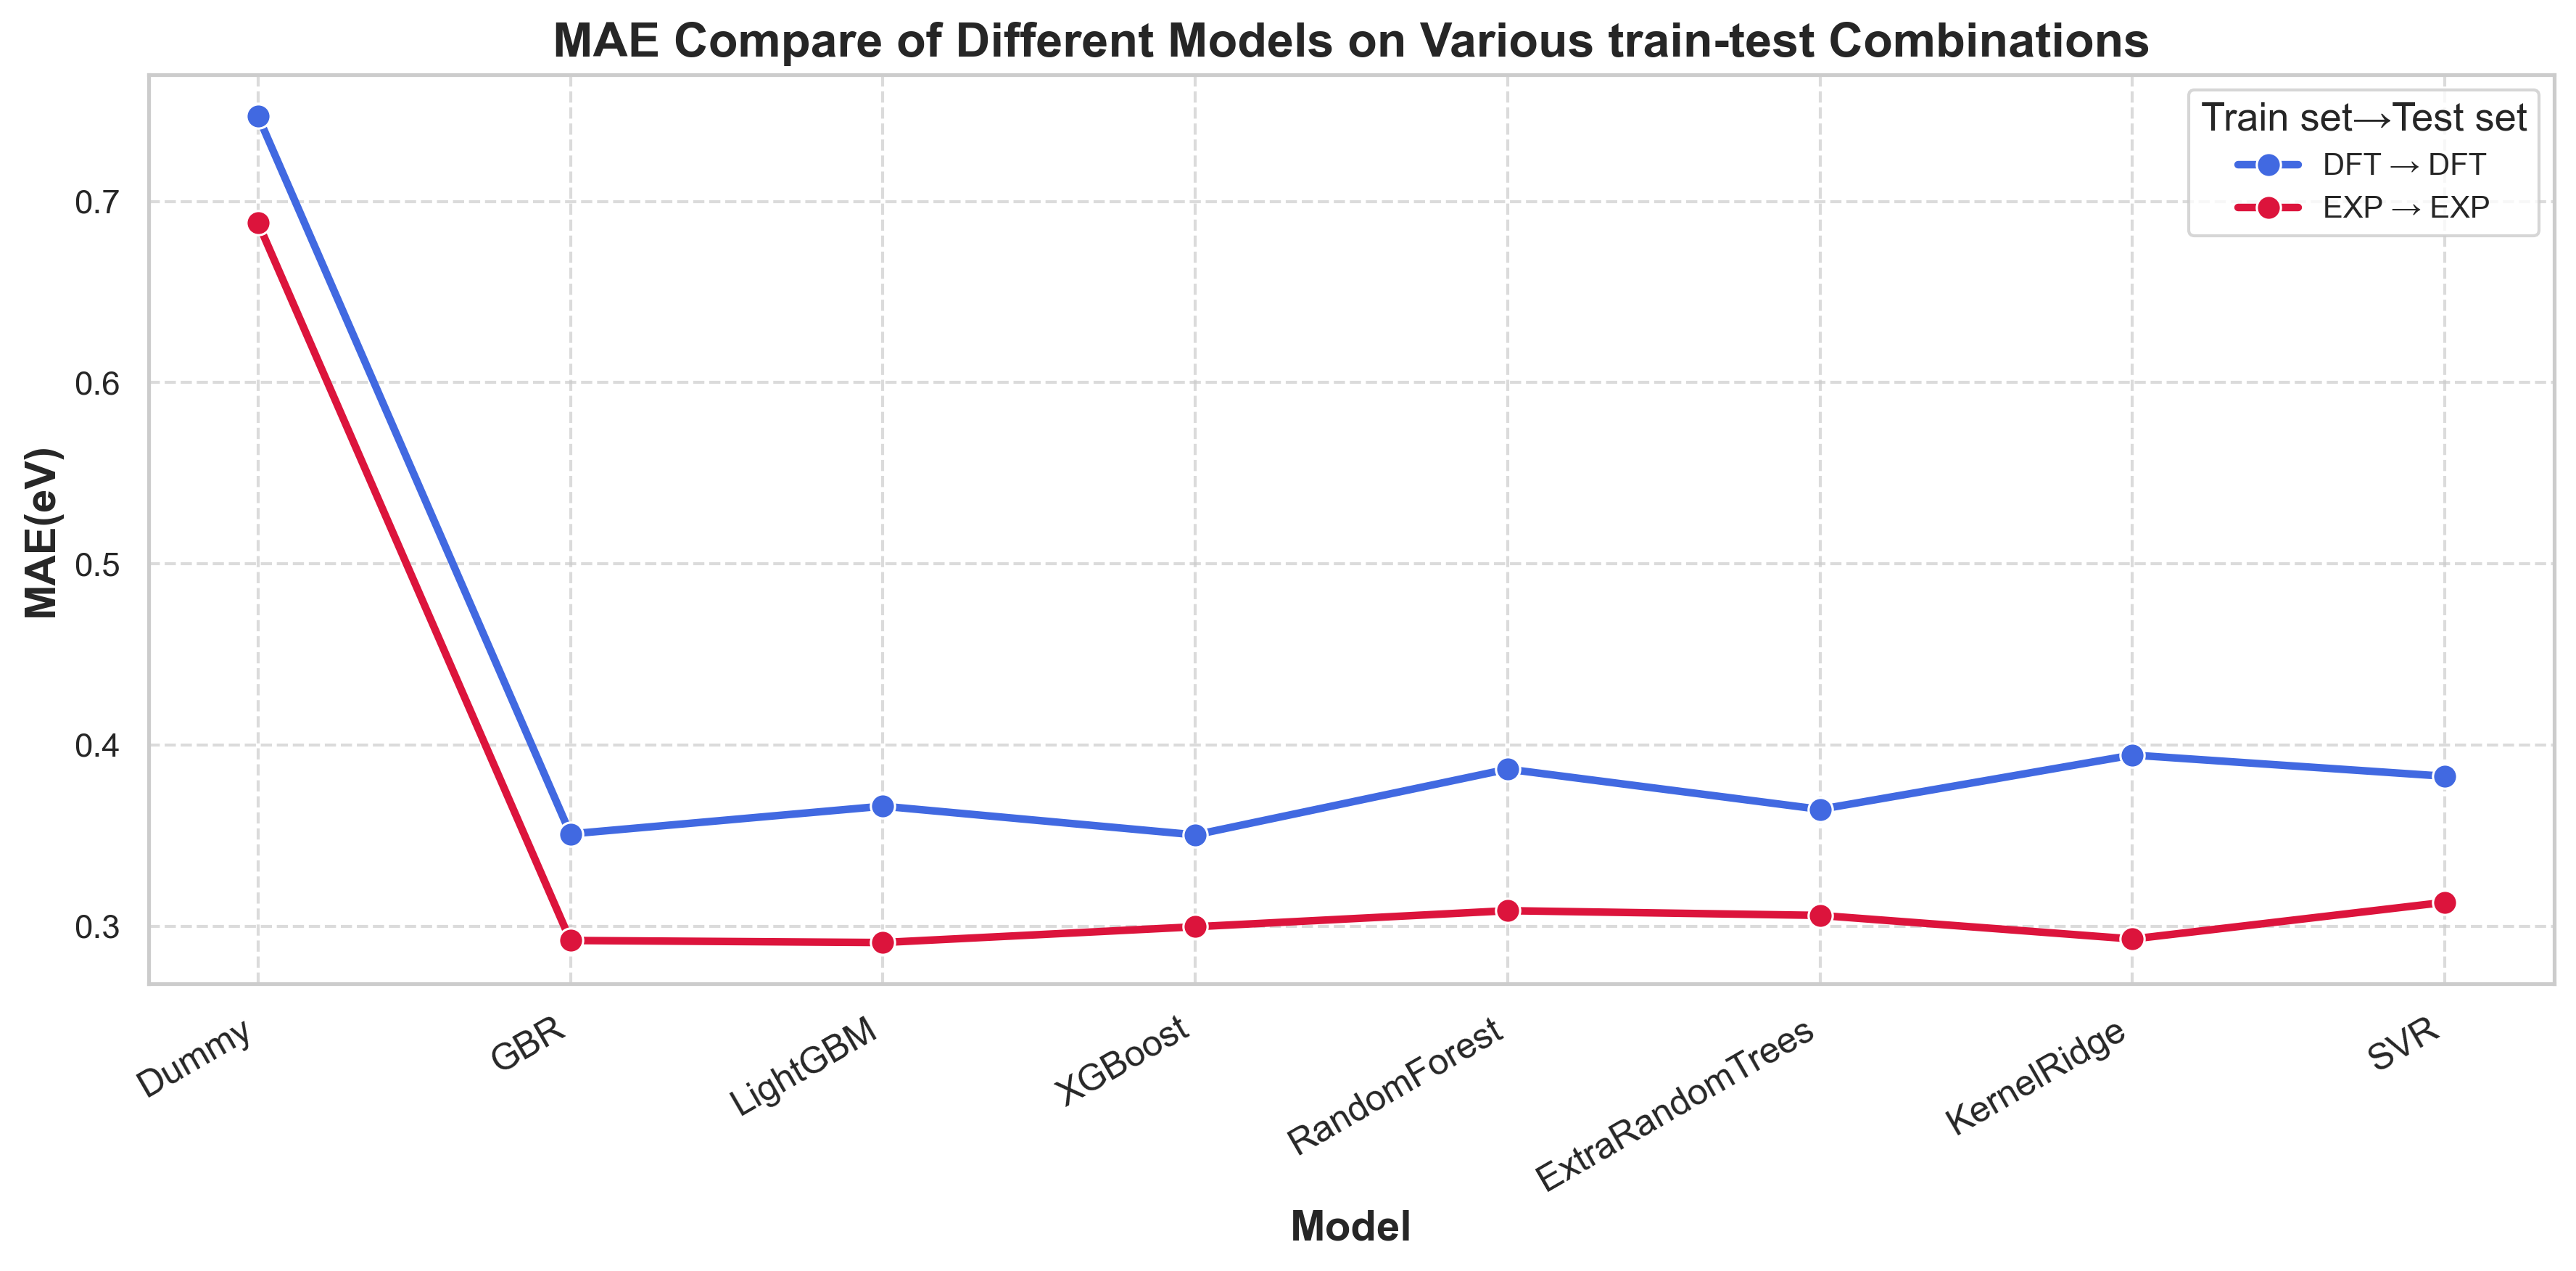

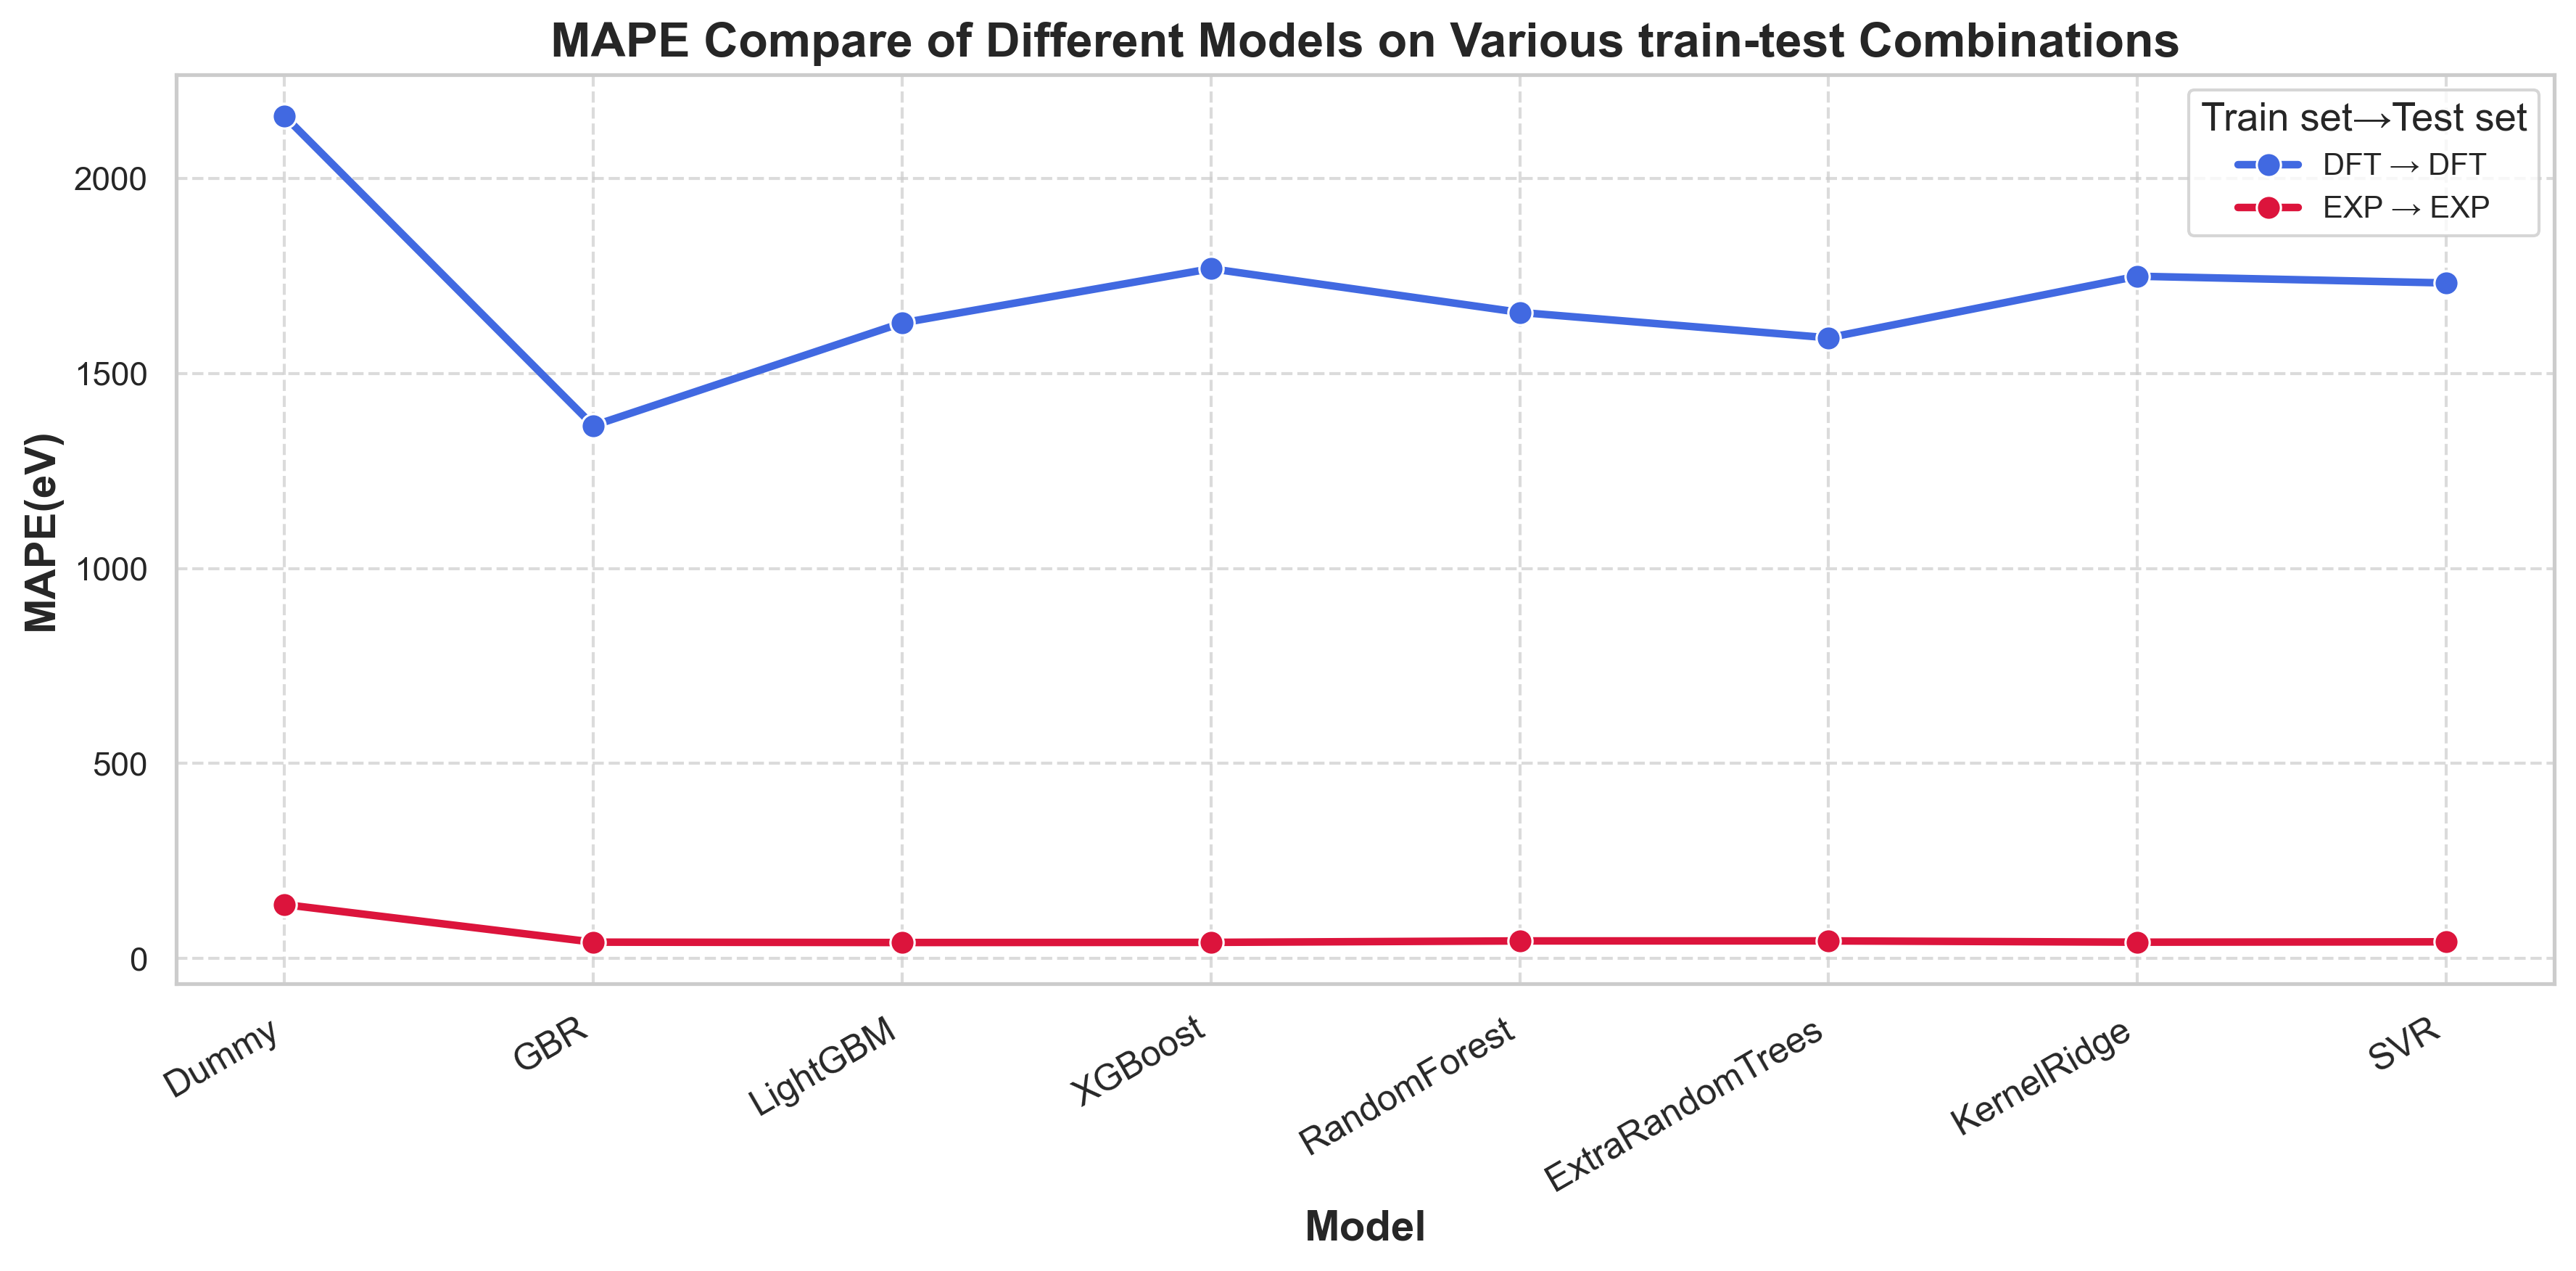

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. draw the metrics comparison figure

for metric_name in ['RMSE', 'R²', 'MAE', 'MAPE']:

    # set style
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6), dpi=300)

    # get unique models
    models = exp_models.keys()

    # prepare data for plotting
    plot_data = []
    for model in models:
        model_metrics = metrics_df[metrics_df['Model'] == f"Single {model}"]
        for _, row in model_metrics.iterrows():
            plot_data.append({
                'Model': row['Model'].split(' ')[-1],
                'Training': row['Train_set'],
                'Testing': row['Test_set'],
                metric_name: row[metric_name]
            })

    plot_df = pd.DataFrame(plot_data)

    # set line styles for different training-testing combinations
    # same dataset training and testing: solid line
    # different dataset training and testing: dashed line
    # dft training: blue; exp training: red
    line_styles = {
        ('dft', 'dft'): {'color': 'royalblue', 'linestyle': '-', 'label': 'DFT → DFT'},

        ('exp', 'exp'): {'color': 'crimson', 'linestyle': '-', 'label': 'EXP → EXP'},
    }

    # plot lines for each model
    for (train_set, test_set), style in line_styles.items():
        data = plot_df[(plot_df['Training'] == train_set) & (plot_df['Testing'] == test_set)]
        if not data.empty:
            sns.lineplot(
                data=data,
                x='Model',
                y=metric_name,
                marker='o',
                markersize=8,
                linewidth=2.5,
                **style
            )

    # beautify the plot
    plt.title(f'{metric_name} Compare of Different Models on Various train-test Combinations', fontsize=16, weight='bold')
    plt.xlabel('Model', fontsize=14, weight='bold')
    plt.ylabel(f'{metric_name}(eV)', fontsize=14, weight='bold')
    plt.xticks(rotation=30, ha='right', fontsize=12)
    # set the legend on the right top corner
    plt.legend(title='Train set→Test set', loc='upper right', fontsize=10, title_fontsize=13)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()  # adjust layout to fit all elements

    # add figure text
    # plt.figtext(0.5, 0.01, 
    #            'Solid: train and test on the same type set | Dashes: train and test on the different type set\n'
    #            'Blue: train on DFT set | Red: train on EXP set\n', 
    #            ha='center', fontsize=11)

    # save the figure
    fig_path = os.path.join(current_path, 'figures', 'metrics_comparison', 'dft_exp_simple')
    os.makedirs(fig_path, exist_ok=True)
    plt.savefig(os.path.join(fig_path, f'{metric_name}_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()